# ML: Predicting Star Ratings


The objective of this project is to predict a new restaurant's popularity from information available when the restaurant opens.  To this end, machine learning is applied on a dataset of venue popularities provided by Yelp. In this dataset, information about the venue includes location, food, service etc. A star rating of the venue is also included. 

### Yelp dataset documentation
https://www.yelp.com/dataset/documentation/main
Each file is composed of a single object type, one JSON-object per-line.
#### business.json
Contains business data including location data, attributes, and categories.
#### review.json
Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
#### user.json
User data including the user's friend mapping and all the metadata associated with the user.
#### checkin.json
Checkins on a business.
#### tip.json
Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.
#### photo.json
Contains photo data including the caption and classification (one of "food", "drink", "menu", "inside" or "outside").

In [23]:
# Import modules and parameters setup
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

import ujson as json
import gzip

#sklearn modules
from sklearn import base


sns.set()

%matplotlib inline

## Load and check out the data

In [2]:
# Load data locally
with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [9]:
# check out the data
print("Data is a %r of %r" % (type(data), type(data[0])))
print("-"*20, "\nHere is the first row: \n", data[0])
print("-"*20, "\nHere is the second row: \n", data[1])
print("-"*20, "\nHere is the last row: \n", data[-1])

Data is a <class 'list'> of <class 'dict'>
-------------------- 
Here is the first row: 
 {'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 7, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}
-------------------- 
Here is the second row: 
 {'business_id': 'JwUE5GmEO-sH1FuwJgKBlQ', 'full_address': '6162 US Highway 51\nDe Forest, WI 53532', 'hours': {}, 'open': True, 'categories': ['Restaurants'], 'city': 'De Forest', 'review_count': 26, 'name

In [5]:
star_ratings = [row['stars'] for row in data]

print("star_rating is a %r" % type(star_ratings))
print("-"*20, "\nHere are some examples: \n", star_ratings[:3])
print("-"*20, "\nThe rating is ranging from %r to %r" % (min(star_ratings), max(star_ratings))) 

star_rating is a <class 'list'>
-------------------- 
Here are some examples: 
 [3.5, 4.0, 4.0]
-------------------- 
The rating is ranging from 1.0 to 5.0


## Exploratory data analysis 

In [12]:
# The loaded data is stored as a dictionary
# Now create a dataframe object, df, to store the data
df = pd.DataFrame.from_dict(data)

In [15]:
# Check out the headers 
df.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,{'By Appointment Only': True},vcNAWiLM4dR7D2nwwJ7nCA,"[Doctors, Health & Medical]",Phoenix,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{'Tuesday': {'close': '17:00', 'open': '08:00'...",33.499313,-111.983758,"Eric Goldberg, MD",[],True,7,3.5,AZ,business
1,"{'Take-out': True, 'Good For': {'dessert': Fal...",JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,"6162 US Highway 51\nDe Forest, WI 53532",{},43.238893,-89.335844,Pine Cone Restaurant,[],True,26,4.0,WI,business
2,"{'Take-out': True, 'Good For': {'dessert': Fal...",uGykseHzyS5xAMWoN6YUqA,"[American (Traditional), Restaurants]",De Forest,"505 W North St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '06:00'}...",43.252267,-89.353437,Deforest Family Restaurant,[],True,16,4.0,WI,business
3,"{'Take-out': True, 'Wi-Fi': 'free', 'Takes Res...",LRKJF43s9-3jG9Lgx4zODg,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,"4910 County Rd V\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '10:30'}...",43.251045,-89.374983,Culver's,[],True,7,4.5,WI,business
4,"{'Take-out': True, 'Has TV': False, 'Outdoor S...",RgDg-k9S5YD_BaxMckifkg,"[Chinese, Restaurants]",De Forest,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}...",43.240875,-89.343722,Chang Jiang Chinese Kitchen,[],True,3,4.0,WI,business


In [14]:
# Check out the columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37938 entries, 0 to 37937
Data columns (total 15 columns):
attributes       37938 non-null object
business_id      37938 non-null object
categories       37938 non-null object
city             37938 non-null object
full_address     37938 non-null object
hours            37938 non-null object
latitude         37938 non-null float64
longitude        37938 non-null float64
name             37938 non-null object
neighborhoods    37938 non-null object
open             37938 non-null bool
review_count     37938 non-null int64
stars            37938 non-null float64
state            37938 non-null object
type             37938 non-null object
dtypes: bool(1), float64(3), int64(1), object(10)
memory usage: 4.1+ MB


#####  Use pandas-profiling library to speed up EDA 

In [31]:
# remove irrelevant columns
df = df.drop(columns=['business_id', 'full_address'])

# use pandas_profiling package to conduct an automatic EDA
pandas_profiling.ProfileReport(df)

In [45]:
# type has only one value: busines, hence remove the dataframe 
df = df.drop(['type'], axis=1)

In [47]:
# look into the variables with a unsurpported type warning from profiling to see what's going on

# variable - attribute
print("Variable: attribute")
print("-"*30, "\nRow1:\n", df['attributes'][0])
print("-"*30, "\nRow2:\n", df['attributes'][1])
print("-"*30, "\nLast row:\n", df['attributes'][len(df['attributes'])-1])

# variable - categories
print("\n\n\nVariable: categories")
print("-"*30, "\nRow1:\n", df['categories'][0])
print("-"*30, "\nRow2:\n", df['categories'][1])
print("-"*30, "\nLast row:\n", df['categories'][len(df['categories'])-1])

# variable - hours
print("\n\n\nVariable: hours")
print("-"*30, "\nRow1:\n", df['hours'][0])
print("-"*30, "\nRow2:\n", df['hours'][1])
print("-"*30, "\nLast row:\n", df['hours'][len(df['hours'])-1])

# variable - neighborhoods
print("\n\n\nVariable: neighborhoods")
print("-"*30, "\nRow1:\n", df['neighborhoods'][0])
print("-"*30, "\nRow2:\n", df['neighborhoods'][1])
print("-"*30, "\nLast row:\n", df['neighborhoods'][len(df['neighborhoods'])-1])


Variable: attribute
------------------------------ 
Row1:
 {'By Appointment Only': True}
------------------------------ 
Row2:
 {'Take-out': True, 'Good For': {'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'breakfast': False, 'brunch': False}, 'Caters': False, 'Noise Level': 'average', 'Takes Reservations': False, 'Delivery': False, 'Ambience': {'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}, 'Parking': {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}, 'Has TV': True, 'Outdoor Seating': False, 'Attire': 'casual', 'Alcohol': 'none', 'Waiter Service': True, 'Accepts Credit Cards': True, 'Good for Kids': True, 'Good For Groups': True, 'Price Range': 1}
------------------------------ 
Last row:
 {'Parking': {'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}, 'Accepts Credit Cards': True,

## Feature engineering

The goal of this step is to find out which features contribute to the star rating. 

First, let's consider variable, city. The average star rating in some cities might be higher than others. Let's test this assumption by comparing the average ratings of different cities. 

In [99]:
df_sorted = df.sort_values(by='city')
df_sorted['id'] = df_sorted.index
df_sorted.head()

,attributes,categories,city,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,id
20361,"{'Take-out': False, 'Good For': {'dessert': Fa...","[Burgers, Fast Food, Restaurants]",Ahwatukee,{},33.348551,-111.975151,McDonald's,[],False,7,2.0,AZ,20361
30499,{'By Appointment Only': True},"[Doctors, Health & Medical, Pediatricians]",Ahwatukee,"{'Tuesday': {'close': '18:30', 'open': '08:00'...",33.308087,-111.980076,Active Kids Pediatrics,[],True,4,5.0,AZ,30499
1718,"{'Parking': {'garage': False, 'street': False,...","[Health Markets, Food, Specialty Food]",Ahwatukee,"{'Monday': {'close': '21:00', 'open': '09:00'}...",33.320339,-111.977310,Hi-Health,[],True,4,2.5,AZ,1718
28608,{'Accepts Credit Cards': True},"[Local Services, Carpet Cleaning]",Ahwatukee,"{'Monday': {'close': '17:00', 'open': '09:00'}...",33.342667,-111.983997,Healthy and Clean Living Environments,[],True,4,4.5,AZ,28608
1740,"{'Alcohol': 'beer_and_wine', 'Noise Level': 'a...","[Gastropubs, Wine Bars, Bars, Nightlife, Resta...",Ahwatukee,"{'Monday': {'close': '22:00', 'open': '15:00'}...",33.333874,-111.977791,My Wine Cellar,[],True,98,4.0,AZ,1740


In [105]:
# Create a new dataframe df_city to contain the unique city names and each city's average star rating

#get unique city names
df_city = pd.DataFrame(df_sorted['city'].unique().tolist(), columns = ['city'])
#get the total counts for each unique city
df_city['counts'] = [i for i in df_sorted.groupby('city')['id'].nunique()]
#average star rating
df_city['avg_stars'] = [i for i in df_sorted.groupby('city')['stars'].mean()]

df_city.head()

,city,counts,avg_stars
0,Ahwatukee,8,3.687500
1,Anthem,55,3.781818
2,Apache Junction,80,3.637500
3,Arcadia,1,5.000000
4,Atlanta,1,3.500000


In [171]:
n_city = len(df_city['city'])
mu = df_city_sorted['avg_stars'].mean()
sigma = df_city_sorted['avg_stars'].std()

print("There are a total of %d cities" % n_city)
print("The mean of average star rating is:", round(mu,2))
print("The standard deviation is:", round(sigma,2))

There are a total of 167 cities
The mean of average star rating is: 3.71
The standard deviation is: 0.58


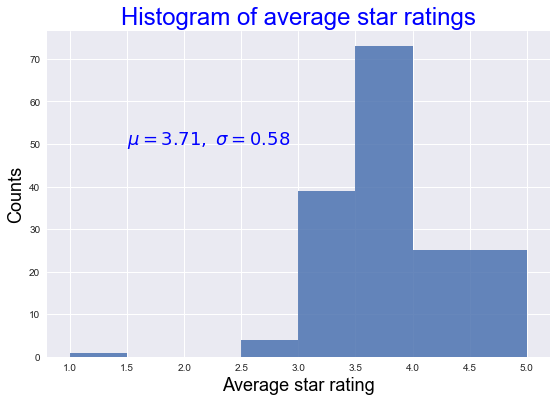

In [161]:
plt.figure(figsize=(9, 6))

plt.hist(df_city_sorted['avg_stars'], [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], alpha=0.85)

plt.title('Histogram of average star ratings', fontsize=24, color='blue')
plt.ylabel('Counts', fontsize=18, color='black')
plt.xlabel('Average star rating', fontsize=18, color='black')

plt.text(1.5, 50, r'$\mu=3.71,\ \sigma=0.58$', fontsize=18, color='blue')

plt.show()

##### Here we can that the average star rating per city mostly varies from 3 to 5, with a mean of 3.71. Only in a few extreme cases, where the average rating of those cities is below 2. 

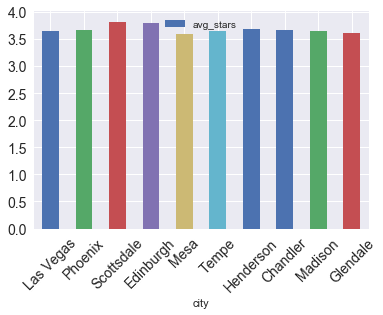

In [167]:
# plot the average rating of the top 10 cities with the most venues on yelp 
df_city_sorted = df_city.sort_values(by=['counts','avg_stars'], ascending=False)
ax = df_city_sorted[:10].plot.bar(x='city', y='avg_stars', rot=45, fontsize=14)

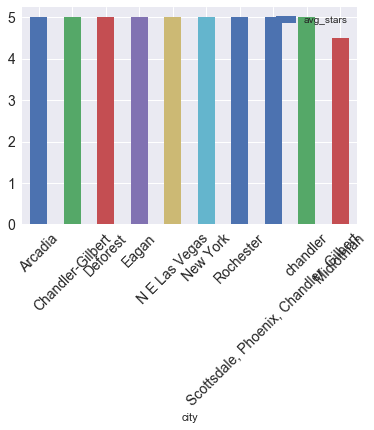

In [169]:
# plot the average rating of the top 10 cities with the higher rating on yelp
df_city_sorted = df_city.sort_values(by=['avg_stars', 'counts'], ascending=False)
ax = df_city_sorted[:10].plot.bar(x='city', y='avg_stars', rot=45, fontsize=14)

## build a model that make prediction of rating based on city 
In this step, a custom estimator is built to make prediction based solely on the city where a restaurant locates. The estimator will receive data as its argument X and star_rating as y. Two methods are included in this estimator: the .fit() method and the .predict() method. 

In [ ]:
class CityEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
    
    def fit(self, X, y):
        """X is the data and y is the star_rating"""
        for row, stars in zip(X, y):
            star_sum[row['city']] += stars
            count[row['city']] += 1
            
        # calculate the average star rating for each city         
        avg_stars = dict()
        for city in star_sum:
            if count[city] == 0:
                avg_stars[city] = 0
            else: 
                avg_stars[city] = star_sum[city]/count[city]
    
        # Store the average rating per city in self.avg_stars
        self.avg_stars = avg_stars
        return self
    
    def predict(self, X, y=None):
        return [self.avg_stars[row['city']] for row in X if row['city'] in self.avg_stars]

Now we can create an instance of our estimator and train it.

In [ ]:
city_est = CityEstimator()
city_est.fit(data, star_ratings)

And let's see if it works.

In [ ]:
city_est.predict(data[:5])

There is a problem, however.  What happens if we're asked to estimate the rating of a venue in a city that's not in our training set?

In [ ]:
city_est.predict([{'city': 'Timbuktu'}])

Solve this problem before submitting to the grader.

## lat_long_model

You can imagine that a city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.

Instead of writing a custom estimator, we'll use one of the built-in estimators in Scikit Learn.  Since these estimators won't know what to do with a list of dictionaries, we'll build a `ColumnSelectTransformer` that will return an array containing selected keys of our feature matrix.  While it is tempting to hard-code the latitude and longitude in here, this transformer will be more useful in the future if we write it to work on an arbitrary list of columns.

In [ ]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return [[row[col_name] for col_name in self.col_names] for row in X]

Let's test it on a single row, just as a sanity check:

In [ ]:
cst = ColumnSelectTransformer(['latitude', 'longitude'])
assert (cst.fit_transform(data[:1])
        == [[data[0]['latitude'], data[0]['longitude']]])

Now, let's feed the output of the transformer in to a `sklearn.neighbors.KNeighborsRegressor`.  As a sanity check, we'll test it with the first 5 rows.  To truly judge the performance, we'd need to make a test/train split.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

data_transform = cst.fit_transform(data)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)
test_data = data[:5]
test_data_transform = cst.transform(test_data)
knn.predict(test_data_transform)

Instead of doing this by hand, let's make a pipeline.  Remember that a pipeline is made with a list of (name, transformer-or-estimator) tuples. 

In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('cst', ColumnSelectTransformer(['latitude', 'longitude'])),
                       ('knn', KNeighborsRegressor(n_neighbors=5))])

# This should work the same way.
pipe.fit(data, star_ratings)
pipe.predict(test_data)

The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction.  There is no reason to believe that 5 is the optimum value.  Determine a better value of this hyperparameter.   There are several ways to do this:

1. Use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) to split your data in to a training set and a test set.  Score the performance on the test set.  After finding the best hyperparameter, retrain the model on the full data at that hyperparameter value.

2. Use [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) to return cross-validation scores on your data for various values of the hyperparameter.  Choose the best one, and retrain the model on the full data.

3. Use [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) to do the splitting, training, and grading automatically.  `GridSearchCV` takes an estimator and acts as an estimator.  You can either give it the `KNeighborsRegressor` directly and put it in a pipeline, or you can pass the whole pipeline into the `GridSearchCV`.  In the latter case, remember that the hyperparameter `param` of an estimator named `est` in a pipeline becomes a hyperparameter of the pipeline with name `est__param`.

No matter which you choose, you should consider whether the data need to be shuffled.  The default k-folds split doesn't shuffle.  This is fine, if the data are already random.  The code below will plot a rolling mean of the star ratings.  Do you need to shuffle the data?

In [ ]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean())

Once you've found a good value of `n_neighbors`, submit the model to the grader.  (*N.B.* "Good" is a relative measure here.  The reference solution has a r-squared value of only 0.02.  There is just rather little signal available for modeling.)

#### Hyper-tuning using train_test_split

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# train on a KneighborsRegressor
def hypertuning_knn(X, y, list_n_neighbors):
    scores_param = {}
    for n in list_n_neighbors:
        pipe = Pipeline([('cst', ColumnSelectTransformer(['latitude', 'longitude'])),
                           ('knn', KNeighborsRegressor(n_neighbors=n))])

        # split the data into training and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        pipe.fit(X_train, y_train)
        scores_param[n] = pipe.score(X_test, y_test)
    return scores_param
    

scores_param = hypertuning_knn(data, star_ratings, list_n_neighbors=[1,3,5,7,9,11,15,21,51])
print(scores_param)

In [ ]:
est.get_params().keys()

In [ ]:
from sklearn.model_selection import GridSearchCV

cst = ColumnSelectTransformer(['latitude', 'longitude'])
X = cst.fit_transform(data)

knn = KNeighborsRegressor()
gs = GridSearchCV(knn, {'n_neighbors':range(65,200)}, cv=5, n_jobs=2, scoring='neg_mean_squared_error')
gs.fit(X, star_ratings)

In [ ]:
sorted(gs.cv_results_.keys())

In [ ]:
print(gs.best_estimator_.score(X,star_ratings))

In [ ]:
print (gs.best_params_)

In [ ]:
knn = KNeighborsRegressor()
knn.get_params().keys()

In [ ]:
!ls ../week2/
#http://localhost:8888/notebooks/Documents/JL/DS/Mini%20challenges/week2/ml-Tandhui.ipynb

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

# train on a RandomForestRegressor
def hypertuning_rfr(X, y, n_estimators):
    scores_param = {}
    for n in n_estimators:
        pipe = Pipeline([('cst', ColumnSelectTransformer(['latitude', 'longitude'])),
                           ('rfr', RandomForestRegressor(n))])

        # split the data into training and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        pipe.fit(X_train, y_train)
        scores_param[n] = pipe.score(X_test, y_test)
    return scores_param
    

In [ ]:
scores_param = hypertuning_rfr(data, star_ratings, n_estimators=[20,300])
print(scores_param)

In [ ]:
### Hyper-tuning cross_val_score
from sklearn.model_selection import cross_val_score
import pandas as pd

# train on a KneighborsRegressor
def hypertuning_knn_cv(X, y, list_cv, list_n_neighbors):
    #scores_param = pd.DataFrame(columns=['cv', 'n_neighbors','score'])
    scores_param = []
    for n in list_cv:
        for m in list_n_neighbors:
            pipe = Pipeline([('cst', ColumnSelectTransformer(['latitude', 'longitude'])),
                               ('knn', KNeighborsRegressor(n_neighbors=m))])
            pipe.fit(X, y)
            score = cross_val_score(pipe, X, y, cv=n)
            scores_param.append(score)
    return scores_param   

In [ ]:
scores_param = hypertuning_knn_cv(data, star_ratings, list_cv = [3,5], list_n_neighbors=[3,5,7,15])
print(scores_param)

*Item for thought:* Why do we choose a non-linear model for this estimator?

*Extension:* Use a `sklearn.ensemble.RandomForestRegressor`, which is a more powerful non-linear model.  Can you get better performance with this than with the `KNeighborsRegressor`?

## category_model

While location is important, we could also try seeing how predictive the
venue's category is.  Build an estimator that considers only the categories.

The categories come as a list of strings, but the built-in estimators all need numeric input.  The standard way to deal with categorical features is **one-hot encoding**, also known as dummy variables.  In this approach, each category gets its own column in the feature matrix.  If the row has a given category, that column gets filled with a 1.  Otherwise, it is 0.

The `ColumnSelectTransformer` from the previous question can be used to extract the categories column as a list of strings.  Scikit Learn provides [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer), which takes in a list of dictionaries.  It creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it.  Missing keys are filled with zeros.  Therefore, we need only build a transformer that takes a list of strings to a dictionary with keys given by those strings and values of one.

In [ ]:
print(data[0])
cat = ColumnSelectTransformer(['categories'])
categories_lis = cat.fit_transform(data)

print("-"*25, "\nThis is a few examples of extracted data:", categories_lis[:3])
print("-"*25, "\nThere are a total of %d category entries" % len(categories_lis))

In [ ]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will come in as a list of lists of lists.  Return a list of
        # dictionaries corresponding to those inner lists.
        cat_encoded =  [{i:1 for i in row[0]} for row in X]
        return cat_encoded

That should allow this to pass:

In [ ]:
assert (DictEncoder().fit_transform([[['a']], [['b', 'c']]])
        == [{'a': 1}, {'b': 1, 'c': 1}])

In [ ]:
encoder = DictEncoder()
categories_encoded = encoder.fit_transform(categories_lis)

print("Here are the first three examples of encoded category data:\n", categories_encoded[:2])

Set up a pipeline with your `ColumnSelectTransformer`, your `DictEncoder`, the `DictVectorizer`, and a regularized linear model, like `Ridge`, as the estimator.  This model will have a large number of features, one for each category, so there is a significant danger of overfitting.  Use cross validation to choose the best regularization parameter.

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import Ridge

dict_vect = DictVectorizer()
tfidf = TfidfTransformer()
rdg = Ridge()


def hypertuning_reg(X, y, list_cv, list_reg):
    scores_param = []
    for n in list_cv:
        for alpha in list_reg:
            pipe = Pipeline([('cat', ColumnSelectTransformer(['categories'])),
                             ('encoder', DictEncoder()),
                             ('dict_vect', DictVectorizer()),
                               ('rdg', Ridge(alpha = alpha))])
            pipe.fit(X, y)
            score = cross_val_score(pipe, X, y, cv=n)
            scores_param.append(score)
    return scores_param


def hypertuning_reg_with_tfidf(X, y, list_cv, list_reg):
    scores_param = []
    for n in list_cv:
        for alpha in list_reg:
            pipe = Pipeline([('cat', ColumnSelectTransformer(['categories'])),
                             ('encoder', DictEncoder()),
                             ('dict_vect', DictVectorizer()),
                             ('tfidf', TfidfTransformer()),
                               ('rdg', Ridge(alpha = alpha))])
            pipe.fit(X, y)
            score = cross_val_score(pipe, X, y, cv=n)
            scores_param.append(score)
    return scores_param

In [ ]:
scores_param = hypertuning_reg(data, star_ratings, list_cv = [3,5], list_reg=[1000.0, 2000.0, 5000.0])
print("hypertuning:\n")

In [ ]:
for row in scores_param:
    print("average score is: ", np.mean(row, dtype=np.float64))

In [ ]:
scores_param = hypertuning_reg_with_tfidf(data, star_ratings, list_cv = [3,5], list_reg=[1000.0, 2000.0, 5000.0])
print("hypertuning:\n")
for row in scores_param:
    print("average score is: ", np.mean(row, dtype=np.float64))

In [ ]:
grader.score('ml__category_model', category_est.predict)  # Edit to appropriate name

*Extension:* Some categories (e.g. Restaurants) are not very specific.  Others (Japanese sushi) are much more so.  One way to deal with this is with an measure call term-frequency-inverse-document-frequency (TF-IDF).  Add in a `sklearn.feature_extraction.text.TfidfTransformer` between the `DictVectorizer` and the linear model, and see if that improves performance.

*Extension:* Can you beat the performance of the linear estimator with a
non-linear model?

## attribute_model

There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them with one-hot encoding.  The `DictVectorizer` can do this, but only once we've flattened the dictionary to a single level, like so:
```
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```

Build a custom transformer that flattens the attributes dictionary.  Place this in a pipeline with a `DictVectorizer` and a regressor.

You may find it difficult to find a single regressor that does well enough.  A common solution is to use a linear model to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit.  Build a residual estimator that takes as an argument two other estimators.  It should use the first to fit the raw data and the second to fit the residuals of the first.

In [ ]:
class FlattenTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self):
        return None  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        attri_flat = []
        for row in X:
            attri_dict = {}
            for key, values in row[0].items():
                if isinstance(values, dict):
                    for values_key, values_value in values.items():
                        attri_dict[key + '_' + values_key] = values_value
                else:
                    attri_dict[key] = values
            attri_flat.append(attri_dict)
        return attri_flat

In [ ]:
pipe = Pipeline([('attri_cst', ColumnSelectTransformer(['attributes'])),
                             ('ft', FlattenTransformer()),
                             ('dict_vect', DictVectorizer()),
                               ('rdg', Ridge(alpha = 1.0))
                ])
pipe.fit(data, star_ratings)
score = cross_val_score(pipe, data, star_ratings, cv=5)


print("Average score is: ", sum(score)/len(score))

In [ ]:
### Linear and non-linear modeling 
pipe = Pipeline([('attri_cst', ColumnSelectTransformer(['attributes'])),
                 ('ft', flattenTransformer()),
                 ('dict_vect', DictVectorizer()),
                 ('rdg', Ridge(alpha = 1.0))
                 ])
pipe.fit(data, star_ratings)
accuracy = cross_val_score(pipe, data, star_ratings, scoring='accuracy', cv=5)
print("Average score is: ", sum(score)/len(score))

In [ ]:
import numpy as np 
y_pred = pipe.predict(data)
print(y_pred[:10])
y_error = star_ratings - y_pred
# y_error = abs(diff.astype(float))
print(y_error[:10])
print(type(y_error))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [ ]:
class ModelTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, linearmodel, nonlinearmodel):
        self.linearmodel = linearmodel
        self.nonlinearmodel = nonlinearmodel
        return None
    
    def fit(self, X, y):
        # When fit() is called, the estimator should be fit. 
        self.linearmodel.fit(X,y)
        y_res = y - self.linearmodel.predict(X)
        self.nonlinearmodel.fit(X,y_res)
        self.y_res = y_res
#         print(y_res.shape())
        #assert self.y_res.shape() == y.shape()
        return self 
    
    def score(self, X, y):
        score = (self.linearmodel.score(X, y) + self.nonlinearmodel.score(X,self.y_res))/2
        return score
    
    def predict(self, X):
        y_pred = self.linearmodel.predict(X) + self.nonlinearmodel.predict(X)
        return y_pred
    

In [ ]:
pipe2 = Pipeline([('attri_cst', ColumnSelectTransformer(['attributes'])),
                  ('ft', flattenTransformer()),
                  ('dict_vect', DictVectorizer()),
                  ('mt', ModelTransformer(Ridge(), RandomForestRegressor()))
                  ])

pipe2.fit(data, star_ratings)

In [ ]:
pipe2.score(data, star_ratings)

In [ ]:
score = cross_val_score(pipe2, data, star_ratings, cv=5)


print("Average score is: ", score.mean())

## full model 
So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to an estimator, we will have to turn them into transformers.  (A pipeline can contain at most a single estimator.)  Build a custom `ModelTransformer` class that takes an estimator as an argument.  When `fit()` is called, the estimator should be fit.  When `transform()` is called, the estimator's `predict()` method should be called, and its results returned.

Note that the output of the `transform()` method should be a 2-D array with a single column, in order for it to work well with the Scikit Learn pipeline.  If you're using NumPy arrays, you can use `.reshape(-1, 1)` to create a column vector.  If you are just using Python lists, you will want a list of lists of single elements.

In [ ]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        # What needs to be done here?
    
    def fit(self, X, y):
        # Fit the stored estimator.
        # Question: what should be returned?
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.

This should work as follows:

In [ ]:
city_trans = EstimatorTransformer(city_est)
city_trans.fit(data, star_ratings)
assert ([r[0] for r in city_trans.transform(data[:5])]
        == city_est.predict(data[:5]))

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [ ]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
        # FeatureUnions use the same syntax as Pipelines
    ])

This should return a feature matrix with four columns.

In [ ]:
union.fit(data, star_ratings)
trans_data = union.transform(data[:10])
assert trans_data.shape == (10, 4)

Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [ ]:
grader.score('ml__full_model', full_est.predict)  # Edit to appropriate name

*Extension:* By combining our models with a linear model, we will be unable to notice any correlation between features.  We don't expect all attributes to have the same effect on all venues.  For example, "Ambiance: divey" might be a bad indicator for a restaurant but a good one for a bar.  Nonlinear models can pick up on this interaction.  Replace the linear model combining the predictions with a nonlinear one like [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).  Better yet, use the nonlinear model to fit the residuals of the linear model.

The score for this question is just a ratio of the score of your model to the score of a reference solution.  Can you beat the reference solution and get a score greater than 1.0?